In [1]:
!pip install --upgrade quantecon

In [2]:
import numpy as np
import quantecon as qe
import matplotlib.pyplot as plt
import scipy.linalg as la

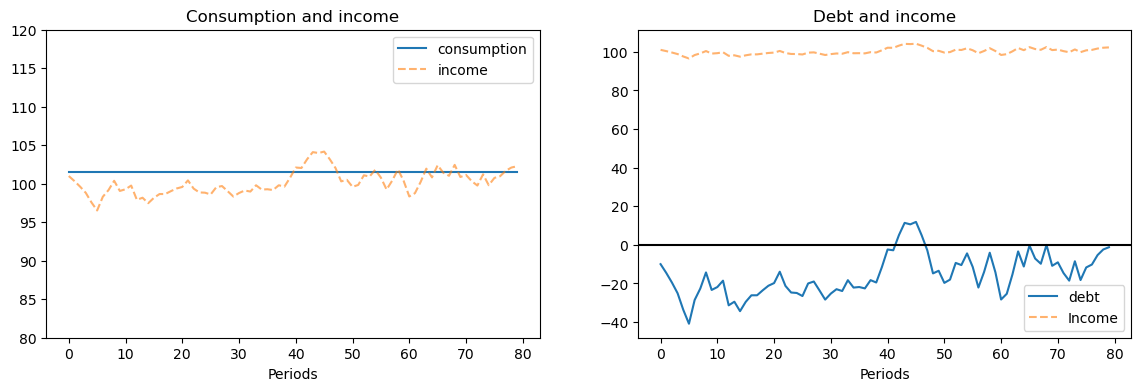

In [3]:
def complete_ss(β, b0, x0, A, C, S_y, T=12):
    """
    Computes the path of consumption and debt for the previously described
    complete markets model where exogenous income follows a linear
    state space
    """
    # Create a linear state space for simulation purposes
    # This adds "b" as a state to the linear state space system
    # so that setting the seed places shocks in same place for
    # both the complete and incomplete markets economy
    # Atilde = np.vstack([np.hstack([A, np.zeros((A.shape[0], 1))]),
    #                   np.zeros((1, A.shape[1] + 1))])
    # Ctilde = np.vstack([C, np.zeros((1, 1))])
    # S_ytilde = np.hstack([S_y, np.zeros((1, 1))])

    lss = qe.LinearStateSpace(A, C, S_y, mu_0=x0)

    # Add extra state to initial condition
    # x0 = np.hstack([x0, np.zeros(1)])

    # Compute the (I - β * A)^{-1}
    rm = la.inv(np.eye(A.shape[0]) - β * A)

    # Constant level of consumption
    cbar = (1 - β) * (S_y @ rm @ x0 - b0)
    c_hist = np.full(T, cbar)

    # Debt
    x_hist, y_hist = lss.simulate(T)
    b_hist = np.squeeze(S_y @ rm @ x_hist - cbar / (1 - β))


    return c_hist, b_hist, np.squeeze(y_hist), x_hist


# Define parameters
N_simul = 80
α, ρ1, ρ2 = 10.0, 0.9, 0.0
σ = 1.0

A = np.array([[1., 0., 0.],
            [α,  ρ1, ρ2],
            [0., 1., 0.]])
C = np.array([[0.], [σ], [0.]])
S_y = np.array([[1,  1.0, 0.]])
β, b0 = 0.95, -10.0
x0 = np.array([1.0, α / (1 - ρ1), α / (1 - ρ1)])

# Do simulation for complete markets
s = np.random.randint(0, 10000)
np.random.seed(s)  # Seeds get set the same for both economies
out = complete_ss(β, b0, x0, A, C, S_y, 80)
c_hist_com, b_hist_com, y_hist_com, x_hist_com = out

fig, ax = plt.subplots(1, 2, figsize=(14, 4))

# Consumption plots
ax[0].set_title('Consumption and income')
ax[0].plot(np.arange(N_simul), c_hist_com, label='consumption')
ax[0].plot(np.arange(N_simul), y_hist_com, label='income', alpha=.6, linestyle='--')
ax[0].legend()
ax[0].set_xlabel('Periods')
ax[0].set_ylim([80, 120])

# Debt plots
ax[1].set_title('Debt and income')
ax[1].plot(np.arange(N_simul), b_hist_com, label='debt')
ax[1].plot(np.arange(N_simul), y_hist_com, label='Income', alpha=.6, linestyle='--')
ax[1].legend()
ax[1].axhline(0, color='k')
ax[1].set_xlabel('Periods')

plt.show()

In [4]:
class ConsumptionProblem:
    """
    The data for a consumption problem, including some default values.
    """

    def __init__(self,
                 β=.96,
                 y=[2, 1.5],
                 b0=3,
                 P=[[.8, .2],
                    [.4, .6]],
                 init=0):
        """
        Parameters
        ----------

        β : discount factor
        y : list containing the two income levels
        b0 : debt in period 0 (= initial state debt level)
        P : 2x2 transition matrix
        init : index of initial state s0
        """
        self.β = β
        self.y = np.asarray(y)
        self.b0 = b0
        self.P = np.asarray(P)
        self.init = init

    def simulate(self, N_simul=80, random_state=1):
        """
        Parameters
        ----------

        N_simul : number of periods for simulation
        random_state : random state for simulating Markov chain
        """
        # For the simulation define a quantecon MC class
        mc = qe.MarkovChain(self.P)
        s_path = mc.simulate(N_simul, init=self.init, random_state=random_state)

        return s_path


def consumption_complete(cp):
    """
    Computes endogenous values for the complete market case.

    Parameters
    ----------

    cp : instance of ConsumptionProblem

    Returns
    -------

        c_bar : constant consumption
        b : optimal debt in each state

    associated with the price system

        Q = β * P
    """
    β, P, y, b0, init = cp.β, cp.P, cp.y, cp.b0, cp.init   # Unpack

    Q = β * P                               # assumed price system

    # construct matrices of augmented equation system
    n = P.shape[0] + 1

    y_aug = np.empty((n, 1))
    y_aug[0, 0] = y[init] - b0
    y_aug[1:, 0] = y

    Q_aug = np.zeros((n, n))
    Q_aug[0, 1:] = Q[init, :]
    Q_aug[1:, 1:] = Q

    A = np.zeros((n, n))
    A[:, 0] = 1
    A[1:, 1:] = np.eye(n-1)

    x = np.linalg.inv(A - Q_aug) @ y_aug

    c_bar = x[0, 0]
    b = x[1:, 0]

    return c_bar, b


def consumption_incomplete(cp, s_path):
    """
    Computes endogenous values for the incomplete market case.

    Parameters
    ----------

    cp : instance of ConsumptionProblem
    s_path : the path of states
    """
    β, P, y, b0 = cp.β, cp.P, cp.y, cp.b0  # Unpack

    N_simul = len(s_path)

    # Useful variables
    n = len(y)
    y.shape = (n, 1)
    v = np.linalg.inv(np.eye(n) - β * P) @ y

    # Store consumption and debt path
    b_path, c_path = np.ones(N_simul+1), np.ones(N_simul)
    b_path[0] = b0

    # Optimal decisions from (12) and (13)
    db = ((1 - β) * v - y) / β

    for i, s in enumerate(s_path):
        c_path[i] = (1 - β) * (v - np.full((n, 1), b_path[i]))[s, 0]
        b_path[i + 1] = b_path[i] + db[s, 0]

    return c_path, b_path[:-1], y[s_path]

In [5]:
cp = ConsumptionProblem()
c_bar, b = consumption_complete(cp)
np.isclose(c_bar + b[1] - cp.y[1] - (cp.β * cp.P)[1, :] @ b, 0)

True

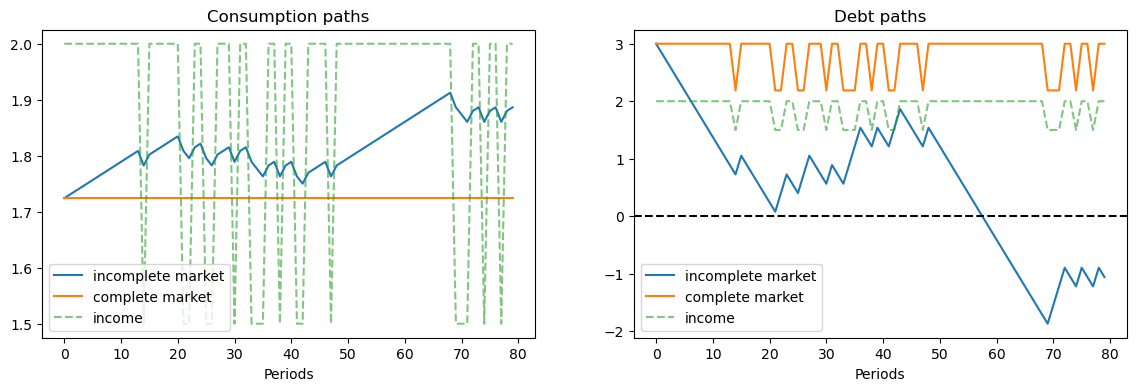

In [6]:
cp = ConsumptionProblem()
s_path = cp.simulate()
N_simul = len(s_path)

c_bar, debt_complete = consumption_complete(cp)

c_path, debt_path, y_path = consumption_incomplete(cp, s_path)

fig, ax = plt.subplots(1, 2, figsize=(14, 4))

ax[0].set_title('Consumption paths')
ax[0].plot(np.arange(N_simul), c_path, label='incomplete market')
ax[0].plot(np.arange(N_simul), np.full(N_simul, c_bar),
                    label='complete market')
ax[0].plot(np.arange(N_simul), y_path, label='income', alpha=.6, ls='--')
ax[0].legend()
ax[0].set_xlabel('Periods')

ax[1].set_title('Debt paths')
ax[1].plot(np.arange(N_simul), debt_path, label='incomplete market')
ax[1].plot(np.arange(N_simul), debt_complete[s_path],
           label='complete market')
ax[1].plot(np.arange(N_simul), y_path, label='income', alpha=.6, ls='--')
ax[1].legend()
ax[1].axhline(0, color='k', ls='--')
ax[1].set_xlabel('Periods')

plt.show()